# Image Classification with finetuned GoogleLeNet 

In my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) I built a small convolutional neural network (CNN) to classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). My goal was to demonstrate how easy one can construct a neural network with descent accuracy (around 70%). However, for many real word problems building CNNs from scratch might not be practical. For instance, in a recent [kaggle](http://kaggle.com/) challenge called [Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats) the competitors were asked to correctly classify images of dogs and cats. In an insightful [interview](http://blog.kaggle.com/2017/04/03/dogs-vs-cats-redux-playground-competition-winners-interview-bojan-tunguz/) the winner of that challenge explained that he didn't rely solely on a CNN that he built from scratch. Instead he got his hands on multiple models already trained with large datasets and applied some "finetuning" in order to make these fit for the specific goal of classifying cats and dogs. So how does this work? The idea is simple. There are hundreds of models already trained on a specific dataset. The largest repository I know is the [Model Zoo Github Repo](https://github.com/BVLC/caffe/wiki/Model-Zoo). There are also the models from the [Tensorflow Slim Project](https://github.com/tensorflow/models/tree/master/slim). So the goal is to select a model that is already trained on a dataset that is similar to the one you are interested in. After selecting the model one has to apply some "finetuning" on it. Interested? Well continue reading, as this is exactly what I am going to do in this post.  

# Cifar-10 Image Dataset

If you are already familiar with my previous post [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html), you might want to skip the next sections and go directly to **Converting datasets to .tfrecord**.

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 colour images in 10 categories - airplanes, dogs, cats, and other objects. The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. Here are the classes in the dataset, as well as 10 random images from each:
<img src="files/dataset_overview.jpg">
The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

## Download the dataset
First, few lines of code will download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
# DOWNLOAD DATASET 
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import tarfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not os.path.isdir('cifar-10-batches-py'):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [05:13, 544KB/s]                               


## Data Overview
The dataset is broken into batches - this is especially useful if one is to train the network on a laptop as it will probably prevent it from running out of memory. I only had 12 GB on mine and a single batch used around 3.2 GB - it wouldn't be possible to load everything at once. Nevertheless, the CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data. Following functions can be used to view different images by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

In [5]:
import pickle
import matplotlib.pyplot as plt

# The names of the classes in the dataset.
CLASS_NAMES = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

LABEL_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(batch_id):

    with open(os.path.join('cifar-10-batches-py','data_batch_' 
              + str(batch_id)), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels


def display_stats(features, labels, sample_id):

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'
              .format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, CLASS_NAMES[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)
    plt.show()

Let's check the first couple of images of each batch. The lines below can be easily modified to show an arbitary image from any batch.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 0:
Image - Min Value: 0 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


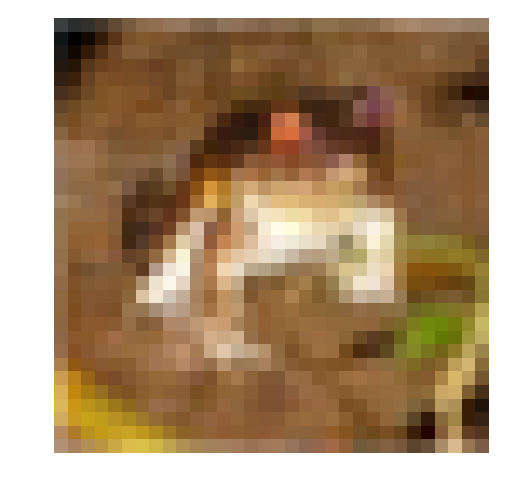


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 1:
Image - Min Value: 5 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 9 Name: truck


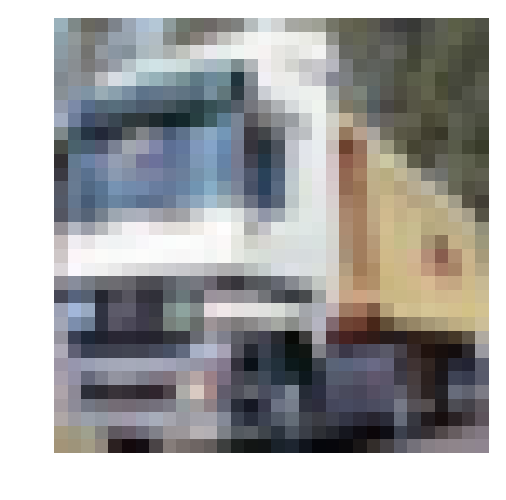


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 0:
Image - Min Value: 5 Max Value: 225
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


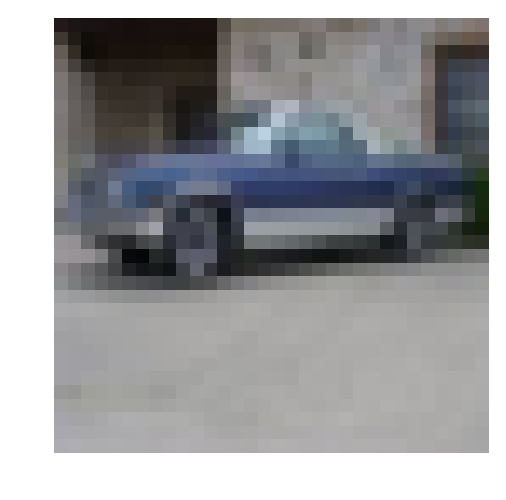


Stats of batch 2:
Samples: 10000
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
First 20 Labels: [1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6]

Example of Image 1:
Image - Min Value: 2 Max Value: 247
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


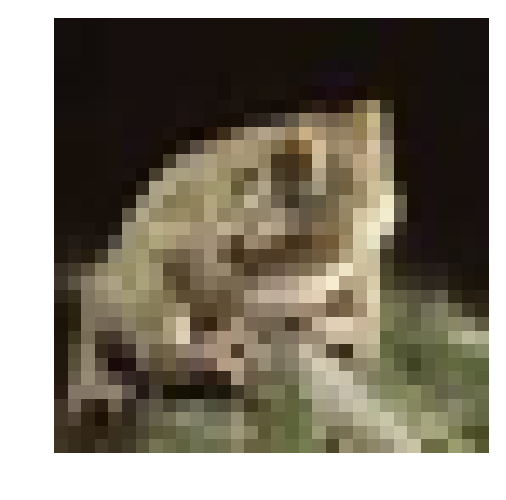


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 0:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


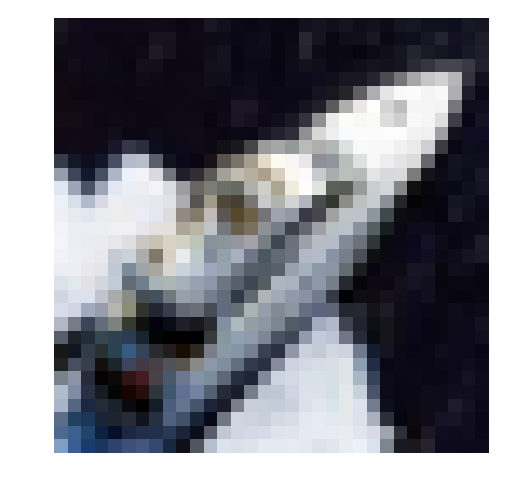


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 1:
Image - Min Value: 15 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 5 Name: dog


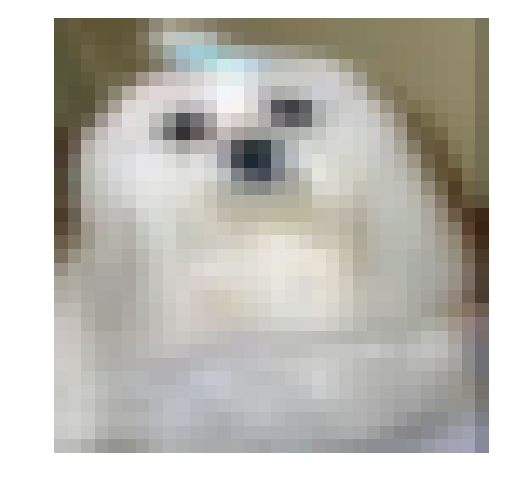


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 0:
Image - Min Value: 34 Max Value: 203
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


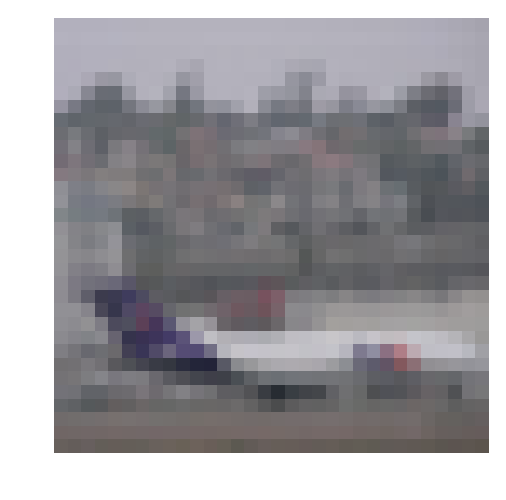


Stats of batch 4:
Samples: 10000
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
First 20 Labels: [0, 6, 0, 2, 7, 2, 1, 2, 4, 1, 5, 6, 6, 3, 1, 3, 5, 5, 8, 1]

Example of Image 1:
Image - Min Value: 0 Max Value: 246
Image - Shape: (32, 32, 3)
Label - Label Id: 6 Name: frog


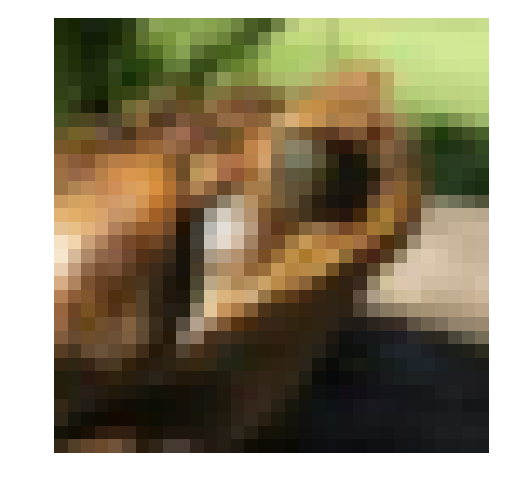


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 0:
Image - Min Value: 2 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


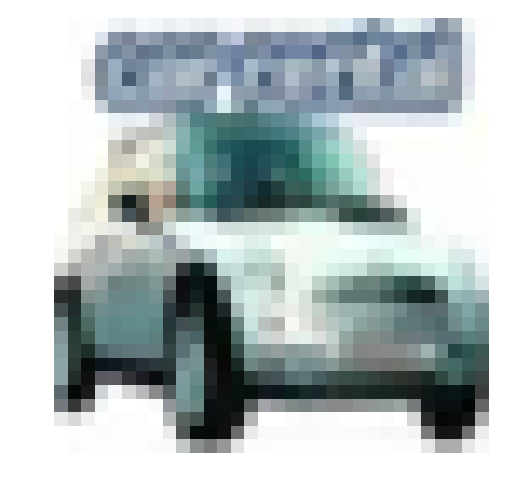


Stats of batch 5:
Samples: 10000
Label Counts: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}
First 20 Labels: [1, 8, 5, 1, 5, 7, 4, 3, 8, 2, 7, 2, 0, 1, 5, 9, 6, 2, 0, 8]

Example of Image 1:
Image - Min Value: 1 Max Value: 244
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


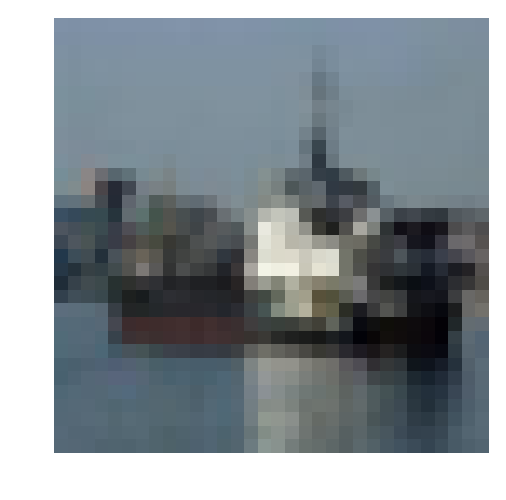

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

for batch_id in range(1,6):
    features, labels = load_cfar10_batch(batch_id)
    for image_id in range(0,2):
        display_stats(features, labels, image_id)

del features, labels # free memory  

# Converting datasets to .tfrecord
Next we convert the datasets to tfrecords. This would allow for the easier further processing by Tensorflow. While the neural network constructed in [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) expected images with size 32x32, the CNN we are going to use here expects an input size of 224x224. Nevertheless, it is not necessary to convert all 60000 images to the target size of 224x224 as this would requre much more of your disk space. Converting the data to tfrecord would actually shrink the dataset size (lossless compression) and allow for the use of tensorflow's preprocessing pipeline and a dynamic conversion to the desired target size of 224x224 at training time.

In [6]:
import sys
import dataset_utils


CIFAR_10_TRAINING_FILENAME = 'cifar-10-training-tfrecord'
CIFAR_10_TEST_FILENAME = 'cifar-10-test-tfrecord'
LABELS_FILENAME = 'labels.txt'

def add_to_tfrecord(filename, tfrecord_writer, offset=0):
    
    with open(filename, mode='rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    images = data['data']
    num_images = images.shape[0]

    images = images.reshape((num_images, 3, 32, 32))
    labels = data['labels']

    with tf.Graph().as_default():
        image_placeholder = tf.placeholder(dtype=tf.uint8)
        encoded_image = tf.image.encode_png(image_placeholder)

        with tf.Session('') as sess:

            for j in range(num_images):
                sys.stdout.write('\r>> Reading file [%s] image %d/%d' % \
                    (filename, offset + j + 1, offset + num_images))
                sys.stdout.flush()

                image = np.squeeze(images[j]).transpose((1, 2, 0))
                label = labels[j]

                png_string = sess.run(encoded_image,\
                         feed_dict={image_placeholder: image})

                example = dataset_utils.image_to_tfexample(\
                    png_string, 'png'.encode('utf-8'), IMAGE_SIZE, IMAGE_SIZE, label)
                tfrecord_writer.write(example.SerializeToString())

    return offset + num_images

with tf.python_io.TFRecordWriter(CIFAR_10_TRAINING_FILENAME) as tfrecord_writer:
    offset = 0
    for i in range(1, 6): # Train batches are data_batch_1 ... data_batch_5
        filename = os.path.join('cifar-10-batches-py', 'data_batch_%d' % (i))
        offset = add_to_tfrecord(filename, tfrecord_writer, offset)

# Next, process the testing data:
with tf.python_io.TFRecordWriter(CIFAR_10_TEST_FILENAME) as tfrecord_writer:
    filename = os.path.join('cifar-10-batches-py', 'test_batch')
    add_to_tfrecord(filename, tfrecord_writer)

# Finally, write the labels file:
labels_to_class_names = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

with tf.gfile.Open(LABELS_FILENAME, 'w') as f:
    for label in labels_to_class_names:
        class_name = labels_to_class_names[label]
        f.write('%d:%s\n' % (label, class_name))

>> Reading file [cifar-10-batches-py/test_batch] image 10000/1000000

In [10]:
# DOWNLOAD INCEPTION V4 MODEL
INCEPTION_V4_2016_09_09 = 'inception_v1_2016_08_28'
INCEPTION_V4_2016_09_09_TAR_GZ = 'inception_v1_2016_08_28.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile('inception_v1_2016_08_28.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='InceptionV4') as pbar:
        urlretrieve(
            # I hope this url stays there
            'http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz',
            'inception_v1_2016_08_28.tar.gz',
            pbar.hook)

if not os.path.isfile('inception_v1.ckpt'):
    with tarfile.open('inception_v1_2016_08_28.tar.gz') as tar:
        tar.extractall()
        tar.close()

InceptionV4: 24.6MB [00:13, 1.78MB/s]                            


In [4]:
import inception_preprocessing

def load_batch(dataset, batch_size, height, width, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [5]:
TRAIN_SAMPLES = 50000

def get_dataset(dataset_file_name, train_sample_size):

    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [32 x 32 x 3] color image.',
        'label': 'A single integer between 0 and 9',
    }

    keys_to_features = {
          'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
          'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
          'image/class/label': tf.FixedLenFeature(
              [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
          'image': slim.tfexample_decoder.Image(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
          'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }

    labels_to_names = {}
    for i in range(0, len(CLASS_NAMES)):
        labels_to_names[i] = CLASS_NAMES[i]

    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    return slim.dataset.Dataset(
          data_sources=dataset_file_name,
          reader=tf.TFRecordReader,
          decoder=decoder,
          num_samples=train_sample_size,
          items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
          num_classes=len(CLASS_NAMES),
          labels_to_names=labels_to_names)

In [8]:
from inception_v1 import inception_v1
from inception_v1 import inception_v1_arg_scope


INCEPTION_IMAGE_SIZE = 224
BATCH_SIZE = 128

slim = tf.contrib.slim

def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/Mixed_5c"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]
    
    variables_to_restore = []
    for var in slim.get_model_variables():
        excluded = False
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                excluded = True
                break
        if not excluded:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join('model','inception_v1.ckpt'),
      variables_to_restore)

train_dir = 'inceptionV1_cifar-10-finetuned'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    train_dataset = get_dataset(CIFAR_10_TRAINING_FILENAME, TRAIN_SAMPLES)
    images, _, labels = load_batch(train_dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v1_arg_scope()):
        logits, _ = inception_v1(images, num_classes=train_dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, train_dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir='finetuned-model_v1',
        init_fn=get_init_fn(),
        number_of_steps=400)
        
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 218: loss = 2.1321 (71.49 sec/step)
INFO:tensorflow:global step 219: loss = 2.1806 (37.72 sec/step)
INFO:tensorflow:global step 220: loss = 2.3524 (36.99 sec/step)
INFO:tensorflow:global step 221: loss = 2.3221 (37.41 sec/step)
INFO:tensorflow:global step 222: loss = 2.4055 (30.94 sec/step)
INFO:tensorflow:global step 223: loss = 2.1539 (32.12 sec/step)
INFO:tensorflow:g

INFO:tensorflow:global step 311: loss = 1.9792 (31.12 sec/step)
INFO:tensorflow:global step 312: loss = 2.0507 (31.46 sec/step)
INFO:tensorflow:global step 313: loss = 2.0311 (30.97 sec/step)
INFO:tensorflow:global step 314: loss = 1.9644 (31.81 sec/step)
INFO:tensorflow:global step 315: loss = 2.0961 (30.85 sec/step)
INFO:tensorflow:global step 316: loss = 1.9520 (31.16 sec/step)
INFO:tensorflow:global step 317: loss = 2.0740 (31.02 sec/step)
INFO:tensorflow:global step 318: loss = 1.9819 (31.70 sec/step)
INFO:tensorflow:global step 319: loss = 2.2044 (31.46 sec/step)
INFO:tensorflow:global step 320: loss = 1.9009 (31.47 sec/step)
INFO:tensorflow:global step 321: loss = 2.0428 (31.42 sec/step)
INFO:tensorflow:global step 322: loss = 1.9324 (32.60 sec/step)
INFO:tensorflow:global step 323: loss = 2.0063 (30.69 sec/step)
INFO:tensorflow:global step 324: loss = 1.9156 (31.20 sec/step)
INFO:tensorflow:global_step/sec: 0.0299979
INFO:tensorflow:global step 325: loss = 1.8974 (43.37 sec/ste

In [9]:
slim = tf.contrib.slim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

BATCH_SIZE = 50
TEST_SAMPLE_SIZE = 10000

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = get_dataset(CIFAR_10_TEST_FILENAME, TEST_SAMPLE_SIZE)
    images, images_raw, labels = load_batch(dataset, BATCH_SIZE, INCEPTION_IMAGE_SIZE, INCEPTION_IMAGE_SIZE)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception_v1_arg_scope()):
        logits, _ = inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint('finetuned-model_v1')
    init_fn = slim.assign_from_checkpoint_fn(checkpoint_path, slim.get_variables_to_restore())
    
    all_accuracy = []
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            all_accuracy = []
            for i in range(int(TEST_SAMPLE_SIZE/BATCH_SIZE)):
                np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
                batch_accuracy = np.mean([np.argmax(prob) == label for label, prob in zip(np_labels, np_probabilities)])
                print('Batch accuracy', batch_accuracy)
                all_accuracy += batch_accuracy
                
            print('All accuracy', np.mean(all_accuracy))

Instructions for updating:
Use `tf.local_variables_initializer` instead.
Batch accuracy 0.54
Batch accuracy 0.48
Batch accuracy 0.48
Batch accuracy 0.46
Batch accuracy 0.48
Batch accuracy 0.48
Batch accuracy 0.54
Batch accuracy 0.48
Batch accuracy 0.44
Batch accuracy 0.38
Batch accuracy 0.52
Batch accuracy 0.58
Batch accuracy 0.5
Batch accuracy 0.3
Batch accuracy 0.46
Batch accuracy 0.52
Batch accuracy 0.46
Batch accuracy 0.42


KeyboardInterrupt: 